In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cookiecats_df = pd.read_csv('data/cookie_cats.csv')
cookiecats_df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
cookiecats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
cookiecats_df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


The sum_gamerounds column is very interesting, because it is extremely high on the high end, which puts the mean above the 3rd quartile! This very skewed tailed distribution is something we should visualize, and also something we should consider scaling or normalizing for a different twist on this task.

In [5]:
cookiecats_df['userid'].duplicated().sum()

0

There are no duplicated users, so that column is perfectly clean

In [6]:
cookiecats_df['version'].value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

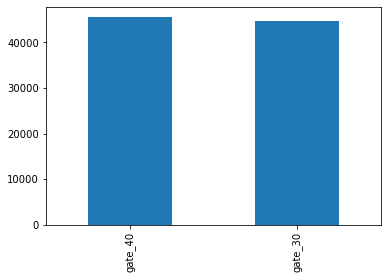

In [7]:
cookiecats_df['version'].value_counts().plot(kind='bar');

The amount of data we are working with in each group is quite balanced, though the new gate being tested, gate 40, has slightly more data, though the amount is probably irrelevant.

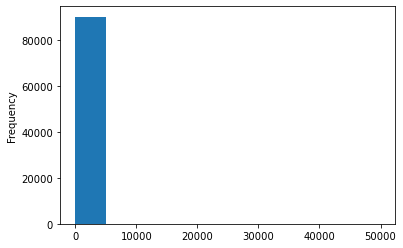

In [8]:
cookiecats_df['sum_gamerounds'].plot(kind='hist');

We seem to have a slight outlier problem when it comes to the gamerounds feature!

In [9]:
cookiecats_df['sum_gamerounds'].sort_values(ascending=False).head(20)

57702    49854
7912      2961
29417     2640
43671     2438
48188     2294
46344     2251
87007     2156
36933     2124
88328     2063
6536      2015
655       1906
18586     1816
27515     1714
13320     1705
11858     1697
19057     1687
83633     1667
12410     1643
33779     1643
10683     1573
Name: sum_gamerounds, dtype: int64

In [10]:
from scipy.stats import zscore

cookiecats_df[['sum_gamerounds']].loc[zscore(cookiecats_df['sum_gamerounds']) > 200]

,sum_gamerounds
57702,49854


So we have one extraordinarily high value. It is debateable whether we should remove it or not, but I think it would be best to remove it for a few reasons.

- It is entirely possible that the value is simply an error, since it is so extreme that it has a zscore above 200! Not that zscore is necessarily the most meaningful metric, but such a result is literally astronomical.
- Our goal is trying to predict player retention in general. Such an outlier as a zscore above 200 is not relevant to predicting player retention for most players, since these players will likely fanatically play the game anyways.
- A value so extreme has the power to inflate results, and it just doesn't seem worth taking this value seriously compared to the others.

In [11]:
cookiecats_df.drop(index=57702, inplace=True)
cookiecats_df['sum_gamerounds'].sort_values(ascending=False).head(20)

7912     2961
29417    2640
43671    2438
48188    2294
46344    2251
87007    2156
36933    2124
88328    2063
6536     2015
655      1906
18586    1816
27515    1714
13320    1705
11858    1697
19057    1687
83633    1667
12410    1643
33779    1643
10683    1573
26308    1559
Name: sum_gamerounds, dtype: int64

Those are still very high, but there are enough of them that it's tolerable. Let's trying plotting again.

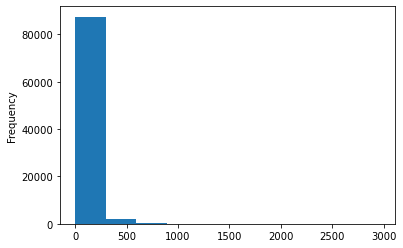

In [12]:
cookiecats_df['sum_gamerounds'].plot(kind='hist');

Actually, due to the sheer amount of data we have, even those top scores may not be plausible to allow. Let's try dropping all data with a zscore above 10, which is more than triple the threshold of what is dropped in many other circumstances, and with zscore it's like orders of magnitude difference.

In [13]:
zscore10 = cookiecats_df[['sum_gamerounds']].loc[zscore(cookiecats_df['sum_gamerounds']) > 10]
zscore10

,sum_gamerounds
655,1906
1097,1374
2257,1309
2586,1252
2692,1315
...,...
85964,1252
86047,1145
86904,1082
87007,2156


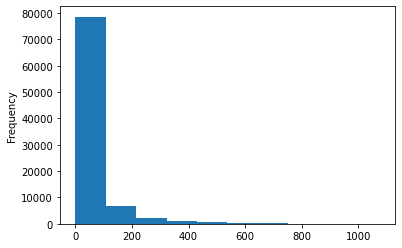

In [14]:
cookiecats_df.drop(index=list(zscore10.index), inplace=True)
cookiecats_df['sum_gamerounds'].plot(kind='hist');

This is still very inflated, so we should probably just go the whole hog and remove anything with a zscore of 3 or greater.

In [15]:
zscore3 = cookiecats_df[['sum_gamerounds']].loc[zscore(cookiecats_df['sum_gamerounds']) > 3]
zscore3

,sum_gamerounds
45,386
237,493
275,391
320,467
346,334
...,...
89921,892
89971,341
90017,438
90115,569


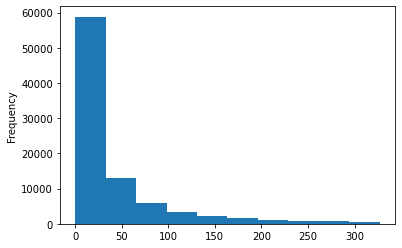

In [16]:
cookiecats_df.drop(index=list(zscore3.index), inplace=True)
cookiecats_df['sum_gamerounds'].plot(kind='hist');

This looks like a much more interesting distribution, though it also looks like an exponential curve, so it might be interesting to transform using the log function. We may try that as a hyperparameter to our test.

In [17]:
cookiecats_df['sum_gamerounds_log'] = cookiecats_df['sum_gamerounds'].apply(np.log)
cookiecats_df['sum_gamerounds_log'].plot(kind='hist');

ValueError: autodetected range of [-inf, 5.7899601708972535] is not finite

Ah, we have a problem because we also have zero values (players who have never really played this game). It's also debateable whether we want to take them into account. We can remove them in another dataframe, and this can be another hyperparameter for our test.

In [18]:
cookiecats_nonzero = cookiecats_df.loc[cookiecats_df['sum_gamerounds'] != 0]
cookiecats_nonzero.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83933 entries, 0 to 90188
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   userid              83933 non-null  int64  
 1   version             83933 non-null  object 
 2   sum_gamerounds      83933 non-null  int64  
 3   retention_1         83933 non-null  bool   
 4   retention_7         83933 non-null  bool   
 5   sum_gamerounds_log  83933 non-null  float64
dtypes: bool(2), float64(1), int64(2), object(1)
memory usage: 3.4+ MB


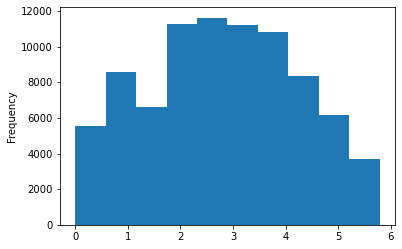

In [19]:
cookiecats_nonzero['sum_gamerounds_log'].plot(kind='hist');

This is a much more interesting distribution that actually resembles a gaussian or normal distribution.

In [20]:
from scipy.stats import normaltest

normaltest(cookiecats_nonzero['sum_gamerounds_log'])

NormaltestResult(statistic=6129.5286637869485, pvalue=0.0)

So this is still almost certainly not normally distributed, though it at least looks more balanced.

We also need to look at the retention rates for the last two columns, and then we are finished with exploring the data.

In [21]:
cookiecats_df['retention_1'].mean()*100

43.22108112411433

So nearly half of the users were retained after one day.

In [22]:
cookiecats_df['retention_7'].mean()*100

16.726375288591672

And about 15% are retained after 7 days, so it would indeed be interesting to explore how modifying the design of the game could alter these retention rates significantly.

In [25]:
cookiecats_abretention1 = cookiecats_df.groupby('version')['retention_1'].agg('mean')
cookiecats_abretention1

version
gate_30    0.435274
gate_40    0.429203
Name: retention_1, dtype: float64

In [27]:
100 - 100*cookiecats_abretention1['gate_40']/cookiecats_abretention1['gate_30']

1.3947441989285352

We have about a 1% decrease in 1 day retention rates with the new level 40 gate

In [28]:
cookiecats_abretention7 = cookiecats_df.groupby('version')['retention_7'].agg('mean')
cookiecats_abretention7, 100 - 100*cookiecats_abretention7['gate_40']/cookiecats_abretention7['gate_30']

(version
 gate_30    0.171410
 gate_40    0.163191
 Name: retention_7, dtype: float64,
 4.794915198223265)

And about a 5% decrease in 7 day retention rates, which seems especially more significant. Now we need to test it.